# Getting more out of your Tado heating system with Python and the Tado API

date: 2023-10-30
tags: api, tado, python
description: How to control your Tado heating system with Python and the Tado API
image: tado-api.png
draft: false
<!--eofm-->


We have recently installed a Tado thermostat to control our heating system. Tado is a "smart" heating system, in the sense that it is internet connected and lets you control your heating via its own app. The app is surprisingly good, but lacking in a few places, and so this got me wondering whether Tado had an API, and whether I could leverage this to get a bit more out of our heating system. The two specific things I wanted to achieve were:
* Be able to access historic temperature measurements. The app lets you do this on a day-by-day basis, but I would like a bit more flexibility to e.g. view a month at a time. I also don't trust that the data will always be available, though I'm happy to be corrected here.
* Better control over scheduling. The app has a pretty versatile scheduler, but as soon as you start getting fiddly with your schedule (e.g. specifying multiple small time blocks), it gets very fiddly to use.

## The Tado API

Having a quick Google around, it seems that Tado does have an API, but it is not supported or documented. Fortunately, some kind folks have created various libraries, and the [Python library `libtado`](https://libtado.readthedocs.io/en/latest/) caught my attention, mainly because it has a function to `set_schedule_blocks` (more on that later).

Installation was easy: `pip install libtado`. Authentication was also surprisingly easy (I hope they employ some rate limiting to stop brute force attacks!), just requiring a client secret that can currently be found by visiting this page - [https://app.tado.com/env.js](https://app.tado.com/env.js) - alongside your username and password.

To connect to the API, I set my username, password and client secret as environment variables and called these from my script:

In [1]:
import os
from libtado.api import Tado

# Get auth tokens from env vars and pass to the API
auth = {
    'username': os.environ['TADO_USERNAME'],
    'password': os.environ['TADO_PASSWORD'],
    'secret': os.environ['TADO_CLIENT_SECRET']
}
api = Tado(**auth)

Note that this interface is slightly different to that specified in `libtado`'s documentation, which says to `import tado.api`, but this didn't work for me.

To get access to the measurement data recorded by your thermostat, the easiest (and possibly only) way seems to use the daily reports. `libtado` provides a convenient `get_report()` function to do this, so let's use this to get today's measurements so far, and plot these on a graph. Note that you need to specify the zone ID for the report, but we only have one zone at the moment and so the ID is just `1`:

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import date

# Get the report for today
report = api.get_report(zone=1,
                        date=date.today().strftime('%Y-%m-%d'))
# get_report returns a dict with all of today's data, including
# weather and heating demand data as well as the measured temperature
# and humidity
report.keys()

dict_keys(['zoneType', 'interval', 'hoursInDay', 'measuredData', 'stripes', 'settings', 'callForHeat', 'weather'])

Let's pull out the measured temperatures from this. The data is represented in quite a fiddly hierarchical dictionary structure, but a simple list comprehension can be used to translate this into NumPy arrays for plotting:

In [3]:
temp_data = report['measuredData']['insideTemperature']['dataPoints']
# Use list comprehensions to create arrays of temperature and times
temp_ts = np.array([x['value']['celsius'] for x in temp_data])
times = np.array([x['timestamp'] for x in temp_data])

We can quickly plot these using Plotly (or another plotting library of your choice!). I first create a Pandas DataFrame in order to make the string to datetime conversion a little simpler.

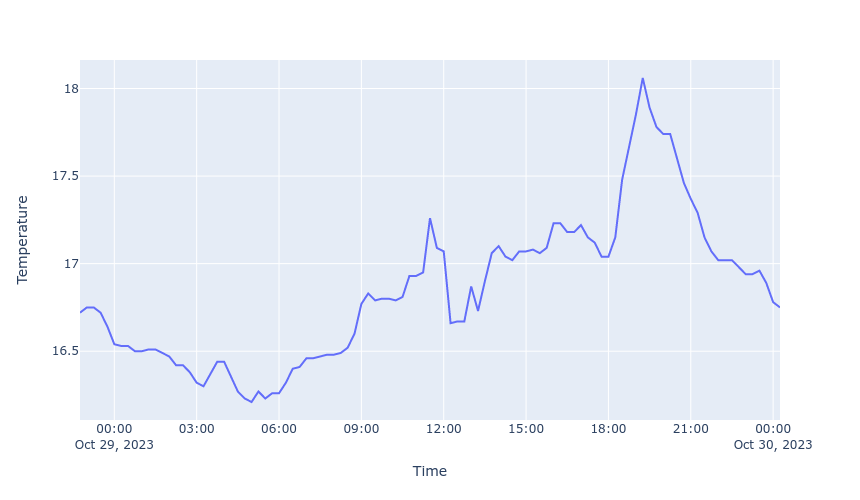

In [20]:
# Save in a dataframe and convert the times to proper timestamps
df = pd.DataFrame({'Time': times, 'Temperature': temp_ts})
df['Time'] = pd.to_datetime(df['Time'])

# Plot
fig = px.line(df, 'Time', 'Temperature')
fig.show(renderer='png', width=860)

## Saving historical data to a database

One of the main reasons I wanted to use the Tado API was to be able to save historical data to my own database, to make it easy to view different date ranges and just in case Tado limits the amount of historical data it stores.

There are a tonnes of ways you could do this, e.g:
* Simply loop over daily reports and dump them to CSV files (`df.to_csv()`), maybe concatenating them into one big CSV as you go.
* Use the Google Sheets API to save the data into a Google Sheets file.
* Create a "proper" database and store the data in there.

The latter seemed the most flexible option. Tado ouputs a fair amount of data (measurements every 15 minutes), and a proper database will more easily cope with this as the database grows over the coming years. I am *not* a database expert, but SQLite seemed a reasonable choice and after a quick Google, it seems that I can get Pandas to do most of the work for me here, with its convenient `df.to_sql()` function. So, let's create one big DataFrame to dump to an SQLite file.

Firstly, I need to loop through all of the days that I want to store in the database. We have only been using the Tado thermostat for 5 days, so that is straighforward. Then I pull the data into separate DataFrames, and finally concatenate them.

In [21]:
dfs = []

# Loop over the days in October that I want the reports for
for day in range(24, 30):
    # Get the report for this day
    report = api.get_report(zone=1,
                            date=f'2023-10-{day}')
    # Get the temperature and humidity data from the report
    temp_data = report['measuredData']['insideTemperature']['dataPoints']
    humidity_data = report['measuredData']['humidity']['dataPoints']
    # Use list comprehensions to create arrays of temperature, humidity and times
    temp_ts = np.array([x['value']['celsius'] for x in temp_data])
    # Multiply humidity by 100 to get a percentage
    humidity_ts = np.array([x['value'] * 100 for x in humidity_data])
    # Here I am relying on temperature and humidity being measured at the
    # same time points
    times = np.array([x['timestamp'] for x in temp_data])
    # Save in a dataframe and convert the times to proper timestamps
    df_ = pd.DataFrame({'Time': times, 'Temperature': temp_ts, 'Humidity': humidity_ts})
    # Convert time from string to a proper datetime
    df_['Time'] = pd.to_datetime(df_['Time'])
    # Add to the list of datafames to concat
    dfs.append(df_)

# Combine the individual daily reports into one big dataframe
df = pd.concat(dfs, ignore_index=True)
df
    

,Time,Temperature,Humidity
0,2023-10-24 13:06:30.865000+00:00,15.63,66.6
1,2023-10-24 13:15:00+00:00,15.56,66.9
2,2023-10-24 13:30:00+00:00,15.53,67.1
3,2023-10-24 13:45:00+00:00,15.50,67.4
4,2023-10-24 14:00:00+00:00,15.50,67.4
...,...,...,...
536,2023-10-29 23:15:00+00:00,16.94,69.7
537,2023-10-29 23:30:00+00:00,16.96,69.5
538,2023-10-29 23:45:00+00:00,16.89,69.6
539,2023-10-30 00:00:00+00:00,16.78,69.6


Now we can save this to a new table in a new SQLite database. We will use the `sqlalchemy` library (`pip install sqlalchemy` or similar) to create a database connection (which is what Pandas expects), which in our case will be to a local file called `heating.db`. Then we pass this to Pandas' `to_sql()` function to create a new table (also called "heating") from our DataFrame:

In [11]:
import sqlalchemy as db

# Create the database engine
engine = db.create_engine('sqlite:///heating.db')

# Connect to the database
with engine.connect() as con:
    # Save our dataframe to a table called "heating"
    df.to_sql('heating', con, if_exists='replace')


To double check this has saved correctly, let's load the data from the database and produce a graph of the full timeseries:

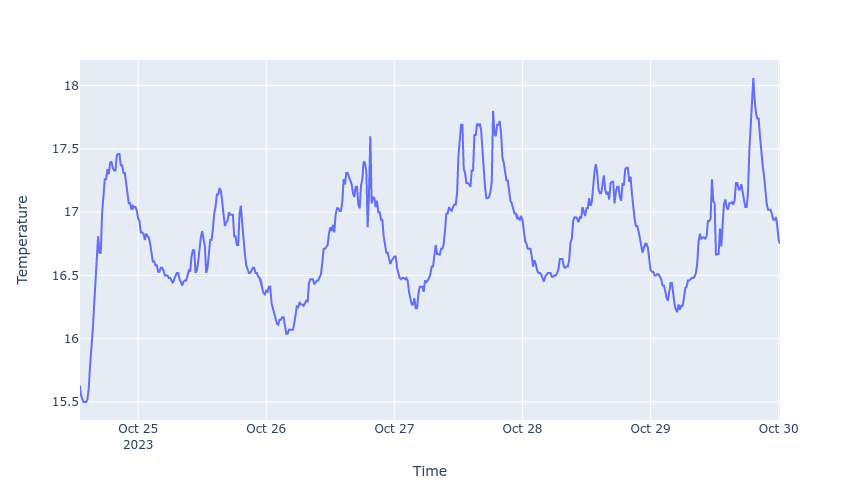

In [19]:
# Connect and read the heating table to a dataframe
with engine.connect() as con:
    df = pd.read_sql_table('heating', con)

# Plot
fig = px.line(df, 'Time', 'Temperature')
fig.show(renderer='png', width=860)

Perfect - I now have a database with all of our historical temperature and humidity data in it! Of course, in practice you would probably want to re-run this to append new data on a daily-or-so basis, but setting up scheduled jobs is beyond this post. You might also want to pull down some of the other useful data from Tado, such as outside temperatures, weather conditions, and heating demand.

## Setting a schedule

The second reason I wanted to use the Tado API was to have a bit of easier control over scheduling. The Tado app is reasonably good for schedules with big time blocks, but fiddly with smaller and/or numerous time blocks. It is also quite limited in the ability to define multiple different schedules and easily switch between them.

Firstly, I need to do a bit of digging to figure out how the Tado API would like the schedule blocks formatted. I am figuring that the JSON format should be the same as that returned by `get_schedule_blocks()`, and so let's first call that on an existing schedule to see what the data structure looks like. For this demo, I have set up an arbitrary schedule that is 20C from 7:30am to 9:30pm, and 18C at other times:

In [24]:
# Firstly, I get the ID of the schedule I am currently using
schedule_id = api.get_schedule(zone=1)['id']
# Then I get the blocks from this schedule
blocks = api.get_schedule_blocks(zone=1, schedule=schedule_id)
blocks

[{'dayType': 'MONDAY_TO_SUNDAY',
  'start': '00:00',
  'end': '07:30',
  'geolocationOverride': False,
  'setting': {'type': 'HEATING',
   'power': 'ON',
   'temperature': {'celsius': 18.0, 'fahrenheit': 64.4}}},
 {'dayType': 'MONDAY_TO_SUNDAY',
  'start': '07:30',
  'end': '21:30',
  'geolocationOverride': False,
  'setting': {'type': 'HEATING',
   'power': 'ON',
   'temperature': {'celsius': 20.0, 'fahrenheit': 68.0}}},
 {'dayType': 'MONDAY_TO_SUNDAY',
  'start': '21:30',
  'end': '00:00',
  'geolocationOverride': False,
  'setting': {'type': 'HEATING',
   'power': 'ON',
   'temperature': {'celsius': 18.0, 'fahrenheit': 64.4}}}]

From this, I can see that Tado wants a list of time blocks that have `dayType`, `start`, `end`, `geolocationOverride` and `setting` keys, with the temperature itself being contained in the `setting` key. That should be pretty easy to replicate.

Let's take a hypothetical scenario: I want the heating to come on for 20 minutes of every hour, from 7am until 10pm. When it's on, I want it to try and reach 17C, and when it's off, I will let it go down to 14C. Rather than writing all of this out, it's easier to generate such a schedule programmatically, using the schema we've just figured out:

In [25]:
blocks = []

# Define a function to set each block based on the schema
def set_block(start, end, temperature):
    return {
        'dayType': 'MONDAY_TO_SUNDAY',
        'start': start,
        'end': end,
        'geolocationOverride': False,
        'setting': {
            'temperature': {'celsius': temperature},
            'type': 'HEATING',
            'power': 'ON',
        }
    }

# Set the start block (midnight to 7am)
blocks.append(set_block('00:00', '07:00', 14.0))

# Loop through each hour between 7am and 10pm and add to the list of blocks
# for the two blocks that will be within that hour
for h in range(7, 22):
    start = f'{h:02d}:00'
    off = f'{h:02d}:20'
    end = f'{h + 1:02d}:00'
    on_block = set_block(start, off, 17.0)
    off_block = set_block(off, end, 14.0)
    blocks.append(on_block)
    blocks.append(off_block)

# Set the end block (10pm to midnight)
blocks.append(set_block('22:00', '00:00', 14.0))

`libtado` has a `set_schedule_blocks()` function. However, I have not managed to get this to work without a 403 error (see [this issue](https://github.com/germainlefebvre4/libtado/issues/201) - <strike>maybe it will be closed by the time you're reading this!</strike> this issue has now been solved in [release 3.7.8](https://github.com/germainlefebvre4/libtado/releases/tag/3.7.8)!). Instead, I am going to access the internal `libtado.api` function `_api_call`, and pass a slightly different URL to that used by `set_schedule_blocks()`. Notably, a "day type" parameter is also passed, which is either "MONDAY_TO_SUNDAY", "MONDAY_TO_FRIDAY" or a day of the week, depending on whether you are setting a one (Monday to Sunday), three (Monday to Friday, Saturday, Sunday) or seven day schedule. 

In [26]:
_ = api._api_call(
    "homes/%i/zones/%i/schedule/timetables/%i/blocks/MONDAY_TO_SUNDAY" % (api.id, 1, schedule_id),
    blocks,
    method="PUT",
)

Your Tado heating system should now be set with the schedule we just created:

![Tado heating scheulde](./tado.png)

## What next?

Of course, this is just the beginning of what you could do with programmatic control over your home heating system! Integration with other services, such as the open-source [Home Assistant](https://www.home-assistant.io/), could be one way to go. Combining with energy usage data could be an excellent way to optimise your heating system to be as efficient as possible, maybe going as far as creating a machine learning model of your home energy usage to help with the task. But I'll save that for another post!